In [1]:
import os

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader, random_split

# Criação do Dataset

In [2]:
def get_data(path):
    """Create a list of pairs of images and labels, based on an input image path, with a given directory organization.

    Example:
        >>> get_data("data/processed/")
        [{"image": "data/processed/images/image_1.jpg", "mask": "data/processed/images/image_1.png"}]

    Args:
        path: Directory path to use when searching for image tiles

    Returns:
        List of dictionaries containing "image" and "label" keys.
    """
    paths = []
    tiles = os.listdir(path)

    # Iterate over all tiles indexes
    for tile in range(1, len(tiles)):
        images = os.listdir(f"{path}/{tile}/images")

        # Add all images within a given tile and its respective mask to the paths list
        for image in images:
            paths.append({"image": f"{path}/{tile}/images/{image}", "label": f"{path}/{tile}/masks/{image}".replace("jpg", "png")})

    return paths

In [3]:
class ProcessedImagesDataset(Dataset):
    """Torch Dataset object to return torch tensors from all available images inside the data folders

    Example:
        >>> paths = get_data("data/processed/")
        >>> dataset = ProcessedImagesDataset(paths)
        >>> type(dataset.__getitem__(0)[0])
        <torch.Tensor>

    Args:
        img_dir: Path to tiles containing images and masks
    """
    def __init__(self, img_dir):
        self.data = get_data(img_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]["image"]
        mask_path = self.data[idx]["label"]
        image, mask = read_image(image_path, ImageReadMode.RGB), (read_image(mask_path, ImageReadMode.GRAY))
        label = np.zeros_like(mask)
        label[mask >= 250] = 1
        return image, label

# Treino

In [4]:
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from scripts.unet import UNet
import torch.optim as optim

In [10]:
def train_fn(loader: DataLoader, model: torch.nn.Module, optimizer: optim.Optimizer, loss_fn, scaler, epochs):
    """Execute main training loop for a given model, using a user-instanciated DataLoader object for training data.

    Args:
        loader: DataLoader object to get pairs of images - labels for training the model
        model: Torch model object matching the input images paramaters
        optimizer: Torch optimizer selected to match the desired type of label image
        loss_fn: Function to calculate the loss values between the predicted images generated by the model
        and the training label images
        scaler: Torch scaler object to accelerate the backward propagation algorithm for the model, and it's loss function
        epochs: How many times to generate a new batch of training images and train the model for
    """
    # Iterate the training steps for a given epoch range
    for epoch in range(epochs):

        # Set the model to accept training operations, such as backward propagations
        model.train()

        batch_loss = 0

        # Iterate over a list of generated batches within the given DataLoader
        for batch_idx, (data, target) in enumerate(loader):

            # Transform input and target images to the desired device to be used, as well
            # as to match the model input type
            data = data.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)

            assert data.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {data.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

            # Perform a forward propagation with the given input data and generate a prediction output
            # as well as the respective loss between the prediction and the target images
            predicted = model(data)
            loss = loss_fn(predicted, target)

            # Perform backwards propagation given the loss function and the
            # selected optimizer algorithm
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Calculate current total batch loss
            batch_loss += loss.item()
        print (f'Epoch [{epoch+1}/{epochs}], Loss: {batch_loss:.4f}')

# Main

In [24]:
def main():
    images_path = "data/processed"

    torch.cuda.empty_cache()
    dataset = ProcessedImagesDataset(images_path)

    # Prepare the data to use during the training loops
    train_data, test_data = random_split(dataset, [50, 22])
    dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    model = UNet(3, 1).to(device=device)

    # Define all parameters and optimizers to be used during training
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
    loss_fn = nn.BCEWithLogitsLoss()
    grad_scaler = torch.cuda.amp.GradScaler()
    epochs = 20

    # Keep track of interruptions to save the model when needed, as well as after the training is finished
    try:
        train_fn(dataloader, model, optimizer, loss_fn, grad_scaler, epochs)
    except KeyboardInterrupt:
        torch.save(model.state_dict(), 'models/INTERRUPTED.pth')
    torch.save(model.state_dict(), 'models/model.pth')
    return model

In [32]:
def evaluate(predictor):
    # Use torch methods without gradient additionalities (as model won't need to be updated)
    with torch.no_grad():

        # Dataset for generating images for the model predictions
        images_path = "data/processed"
        dataset = ProcessedImagesDataset(images_path)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

        # Set predictor to use the evaluation settings
        predictor.eval()

        # For each batch of images in the dataloader (batch_size == 1),
        # display to user the sequence of original images, true masks and respective predicted labels
        for idx, batch in enumerate(dataloader):
            image, label = batch
            predicted = torch.sigmoid(predictor(image.to(device, torch.float32)))
            predicted = np.transpose(predicted[0].cpu(), axes=[1, 2, 0])
            mask = np.copy(predicted)
            mask.reshape((mask.shape[0], mask.shape[1]))
            mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
            mask[mask < 0.6] = 0

            plt.subplot(131)
            plt.imshow(np.transpose(image[0], axes=[1, 2, 0]), cmap="gray")
            plt.subplot(132)
            plt.imshow(np.transpose(label[0], axes=[1, 2, 0]), cmap="gray")
            plt.subplot(133)
            plt.imshow(mask, cmap="gray")
            plt.savefig(f"predictions/unet/img_{idx}.png")

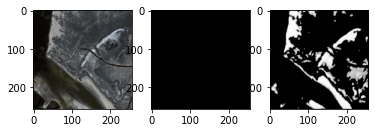

In [33]:
use_trained = True

if __name__ == "__main__":
    if not use_trained:
        predictor = main()
    else:
        predictor = UNet(3, 1).to(device=device)
        predictor.load_state_dict(torch.load("models/model.pth"))
    evaluate(predictor)